In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from itertools import product, chain
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 数据读取

In [2]:
path = './data/'
data = pd.read_csv(path + 'PRSA_data_2010.1.1-2014.12.31.csv', 
                   parse_dates=[['year', 'month', 'day', 'hour']],
                   date_parser=lambda y, m, d, h: datetime.strptime(' '.join([y, m, d, h]), '%Y %m %d %H'))
data.drop('No', axis=1, inplace=True)
data.head(3)

,year_month_day_hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0


In [3]:
data.columns = ['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.set_index('date', inplace=True)
data.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [5]:
# 查看数据集可知，2010年1月1日PM2.5值缺失，去掉这一天数据
data = data[data.index >= '2010-1-2']
data.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0


In [6]:
# 说明数据集中间仍存在数据缺失的情况
data.isna().sum()

pollution    2043
dew             0
temp            0
press           0
wnd_dir         0
wnd_spd         0
snow            0
rain            0
dtype: int64

In [7]:
# 采用线性插值进行缺失值填充
data['pollution'] = data['pollution'].interpolate()
data.isna().any().any()

False

## 使用ARIMA模型进行预测

### 预测未来3天的PM2.5
将数据转换为每日均值，并预测2014年最后3天的结果，与真实值进行比较。

In [8]:
df_day = data['pollution'].resample('d').mean()
df_day.head(3).append(df_day.tail(3))

date
2010-01-02    145.958333
2010-01-03     78.833333
2010-01-04     31.333333
2014-12-29    159.000000
2014-12-30     46.083333
2014-12-31     10.041667
Name: pollution, dtype: float64

In [9]:
df_day = data[['pollution']].resample('d').mean()
df_day.head(3).append(df_day.tail(3))

,pollution
date,
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2014-12-29,159.000000
2014-12-30,46.083333
2014-12-31,10.041667


In [10]:
tra_data = df_day.iloc[:-3]
y = df_day.iloc[-3:]

In [38]:
%%time
best_aic = float('inf')
for p, d, q in product(range(6), range(3), range(6)):
    try:
        print(f'当前order = {(p, d, q)}', end='\r')
        arima_model = ARIMA(tra_data, order=(p, d, q)).fit()
        if arima_model.aic < best_aic:
            best_aic = arima_model.aic
            best_order = (p, d, q)
            best_model = arima_model
    except ValueError:
        pass
print(f"最优阶数为(p, d, q) = {best_order}，模型aic = {best_aic}.")
best_model.summary()

最优阶数为(p, d, q) = (5, 1, 4)，模型aic = 20220.119972618304.
CPU times: user 26min 57s, sys: 16min 51s, total: 43min 49s
Wall time: 27min 49s


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.pollution   No. Observations:                 1821
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -10099.060
Method:                       css-mle   S.D. of innovations             61.802
Date:                Sun, 03 Jan 2021   AIC                          20220.120
Time:                        13:43:57   BIC                          20280.699
Sample:                    01-03-2010   HQIC                         20242.469
                         - 12-28-2014                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0018      0.008     -0.226      0.821      -0.017       0.014
ar.L1.D.pollution     0.0051      0.022      0.232      0.817      -0.038       0.048
ar.L2.D.pollution     0.8091      0.018     44.625      0.000       0.774       0.845
ar.L3.D.pollution     0.4808      0.025     19.238      0.000       0.432       0.530
ar.L4.D.pollution    -0.5116      0.020    -26.162      0.000      -0.550      -0.473
ar.L5.D.pollution     0.1593      0.023      6.865      0.000       0.114       0.205
ma.L1.D.pollution    -0.3290        nan        nan        nan         nan         nan
ma.L2.D.pollution    -1.2209        nan        nan        nan         nan         nan
ma.L3.D.pollution    -0.4039        nan        nan        nan         nan         nan
ma.L4.D.pollution     0.9538        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8163           -0.5936j            1.0093           -0.3999
AR.2           -0.8163           +0.5936j            1.0093            0.3999
AR.3            1.0311           -0.0000j            1.0311           -0.0000
AR.4            1.9068           -1.5303j            2.4449           -0.1076
AR.5            1.9068           +1.5303j            2.4449            0.1076
MA.1           -0.8125           -0.5831j            1.0000           -0.4009
MA.2           -0.8125           +0.5831j            1.0000            0.4009
MA.3            1.0000           -0.0000j            1.0000           -0.0000
MA.4            1.0484           -0.0000j            1.0484           -0.0000
-----------------------------------------------------------------------------
"""

In [39]:
# 预测结果
arima_model.predict('2014-12-29', '2014-12-31')

2014-12-29    44.943715
2014-12-30    17.555884
2014-12-31    25.247305
Freq: D, dtype: float64

In [40]:
# 实际结果
y

,pollution
date,
2014-12-29,159.000000
2014-12-30,46.083333
2014-12-31,10.041667


可见ARIMA模型的预测结果与实际结果还是有一定差距。

### 可视化分析
对2014年的真实值、ARIMA在训练集的拟合曲线、以及对2014年最后3天PM2.5的预测值进行可视化，从下图可见，模型拟合效果确实不太好。

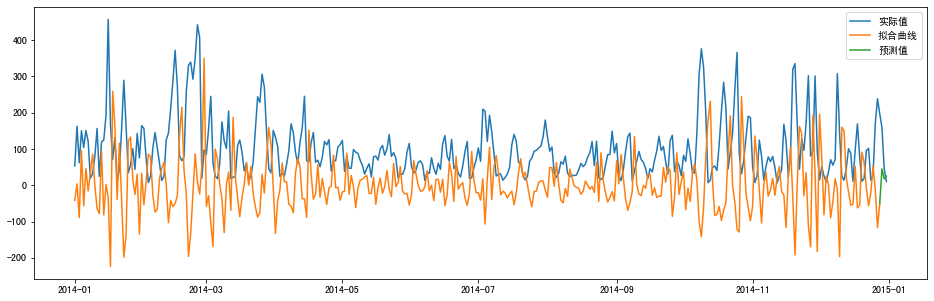

In [41]:
plt.figure(figsize=(16, 5))
plt.plot(df_day.loc['2014':], label='实际值')
plt.plot(arima_model.predict('2014', '2014-12-28'), label='拟合曲线')
plt.plot(arima_model.predict('2014-12-28', '2014-12-31'), label='预测值')
plt.legend()

## 使用LSTM模型进行预测

由于深度学习需要优化的参数较多，因此这里还是使用原始的按小时采样的数据，免得按天取平均得到的数据量太少（1825）.

In [12]:
!pip install keras

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
#     print(reframed_train_data_set)
#     print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    # test_data是用于计算correlation与spearman-correlation而存在
    test_data = train_data_set[train_x.shape[0] + timesteps_out:, :]
    #pd.DataFrame(reframed_train_data_set).to_csv('temp.csv')
    return train_x, train_y, test_data

In [15]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

In [27]:
# 使用LSTM进行预测
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, test_data, timesteps_out):
    model = Sequential()  
    # 第一层, 隐藏层神经元节点个数为128, 返回整个序列
    model.add(LSTM(32, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.5))
    # 第三层 因为是回归问题所以使用linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # LSTM训练 input_epochs次数
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)
    # 模型预测
    test_predict = model.predict(train_x)  
    # 串联多个迭代对象，形成更大的迭代对象
    test_data_list = list(chain(*test_data))
    test_predict_list = list(chain(*test_predict))
    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, test_predict)

Epoch 1/100
438/438 - 1s - loss: 16766.9648
Epoch 2/100
438/438 - 1s - loss: 15498.8115
Epoch 3/100
438/438 - 1s - loss: 14525.7441
Epoch 4/100
438/438 - 1s - loss: 13653.4336
Epoch 5/100
438/438 - 1s - loss: 12875.4609
Epoch 6/100
438/438 - 1s - loss: 12166.0420
Epoch 7/100
438/438 - 1s - loss: 11495.3145
Epoch 8/100
438/438 - 1s - loss: 10894.9590
Epoch 9/100
438/438 - 1s - loss: 10364.5010
Epoch 10/100
438/438 - 1s - loss: 9843.8945
Epoch 11/100
438/438 - 1s - loss: 9361.8281
Epoch 12/100
438/438 - 1s - loss: 8918.0381
Epoch 13/100
438/438 - 1s - loss: 8531.0488
Epoch 14/100
438/438 - 1s - loss: 8147.2134
Epoch 15/100
438/438 - 1s - loss: 7800.8423
Epoch 16/100
438/438 - 1s - loss: 7493.0410
Epoch 17/100
438/438 - 1s - loss: 7221.6748
Epoch 18/100
438/438 - 1s - loss: 6933.5879
Epoch 19/100
438/438 - 1s - loss: 6693.0894
Epoch 20/100
438/438 - 1s - loss: 6427.8291
Epoch 21/100
438/438 - 1s - loss: 6233.4194
Epoch 22/100
438/438 - 1s - loss: 6014.0977
Epoch 23/100
438/438 - 2s - loss

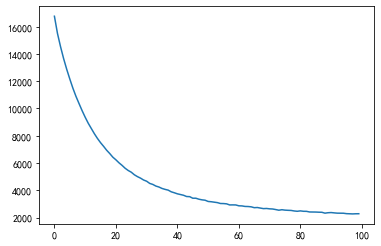

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 3, 32)             4352      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 7,539
Trainable params: 7,539
Non-trainable params: 0
_________________________________________________________________
None


TypeError: '(slice(None, None, None), -1)' is an invalid key

<Figure size 1728x576 with 0 Axes>

In [28]:
%%time
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 100
batch_size = 100
# 转化为可以用于监督学习的数据
train_x, label_y, test_data = get_train_set(data[['pollution']], timesteps_in, timesteps_out)
# 使用LSTM进行训练、预测
lstm_model(data[['pollution']], train_x, label_y, epochs, batch_size, test_data, timesteps_out=timesteps_out)